In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
import random
import copy

import sys
sys.path.append("Fall 2024")

import kmax as kx
import utility as util
from hierarchy import *
import z_solver as zs

# Continuous Edge Weights - Transition Probabilities

## Function Definitions

In [2]:
def get_section(Z_val):
    if Z_val <= 0:
        return 0
    else:
        return int(Z_val // (1 / num_sections))

## Simulation

In [3]:
num_samples = 1000
lam = 0.7
offspring_dist = lambda: np.random.poisson(lam)
edge_dist = lambda: np.random.uniform(0,1)

In [4]:
# Setup transition count matrix
num_sections = 10
section_bounds = np.linspace(0.0, 1.0, num_sections+1)
transition_counts = np.zeros(shape=(num_sections+1,num_sections+1),
                             dtype=int)

In [5]:
for _ in range(num_samples):
    # Generate tree
    tree = nx.Graph(GWBP(dist=offspring_dist, MAXLEVEL=10))
    for u,v in tree.edges():
        tree[u][v]['weight'] = edge_dist()

    if tree.number_of_nodes() == 1:
        transition_counts[0][0] += 1
        continue
    
    # Get Z values, children
    tups = util.path_cover(tree, root=0, return_tuples=True)
    Z = {v:tup[1] for v,tup in tups}
    v1 = {v:tup[2] for v,tup in tups}
    v2 = {v:tup[3] for v,tup in tups}

    current_node = v1[0] # first max child of root 0
    while True:
        current_section = get_section(Z[current_node]) + 1
        if v1[current_node] is not None:
            v1_section = get_section(Z[v1[current_node]]) + 1
            transition_counts[current_section][v1_section] += 1
            if Z[v1[current_node]] < 0:
                break
            else:
                current_node = v1[current_node]
        else:
            transition_counts[current_section][0] += 1
            break

Each component `transition_counts[i][j]` represents the number of times an edge $(v_1,v_2)$ has $Z(v_1)$ in subsection $i$ and $Z(v_2)$ in subsection $j$.
That is, the row index is the source state and the column index is the end state.

In [6]:
my_shape = transition_counts.shape
transition_probs = np.ndarray(shape=my_shape, dtype=float)
row_sums = sum(np.transpose(transition_counts))
for i in range(my_shape[0]):
    for j in range(my_shape[1]):
        transition_probs[i][j] = transition_counts[i][j] / row_sums[i]

Rows sum to 1:

In [7]:
for i in range(num_sections+1):
    print(sum(transition_probs[i]))

1.0
1.0
0.9999999999999998
0.9999999999999999
1.0
0.9999999999999999
0.9999999999999998
0.9999999999999998
1.0000000000000002
1.0000000000000002
0.9999999999999998


### 3d Plot

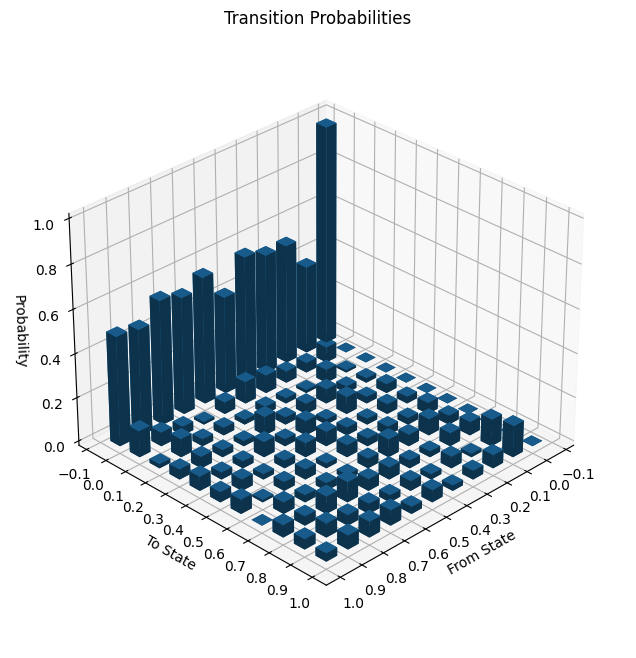

In [8]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('auto', anchor='C')

#coord matrices
x_len, y_len = transition_probs.shape

bar_scale = 0.5
dx = dy = bar_scale * (1 / num_sections)
dz = transition_probs.T.flatten()

bar_positions = section_bounds - (1 / (2 * num_sections)) - (1/4) * dx
xpos, ypos = np.meshgrid(bar_positions, bar_positions)
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros_like(xpos)

ax.bar3d(xpos, ypos, zpos, dx, dy, dz)

ax.set_xlabel('From State')
ax.set_ylabel('To State')
ax.set_zlabel('Probability')
ax.set_title('Transition Probabilities')

ax.set_xticks(np.concatenate(([-(1 / num_sections)], section_bounds)))
ax.set_yticks(np.concatenate(([-(1 / num_sections)], section_bounds)))

ax.view_init(elev=30, azim=45, roll=0)
ax.set_box_aspect(None, zoom=0.9)
plt.show()

### Heatmap

#### Color plotter from matplotlib docs

In [9]:
# https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current Axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(range(data.shape[1]), labels=col_labels,
                  rotation=-30, ha="right", rotation_mode="anchor")
    ax.set_yticks(range(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

#### Plot

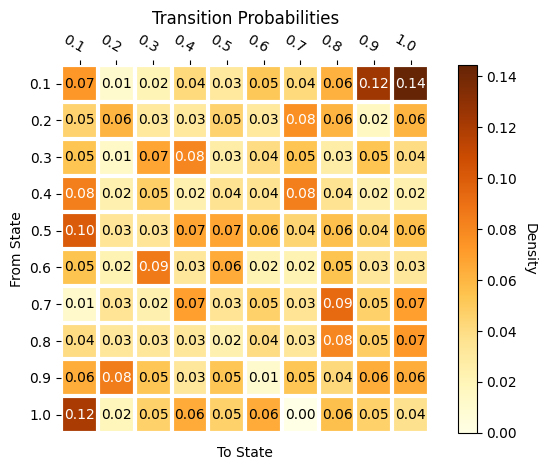

In [10]:
data = transition_probs[1:,1:]
labels = [str(s)[:3] for s in section_bounds[1:]]
fig, ax = plt.subplots()

im, cbar = heatmap(data, labels, labels, ax=ax,
                   cmap="YlOrBr", cbarlabel="Density")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

plt.title('Transition Probabilities')
plt.xlabel('To State')
plt.ylabel('From State')

fig.tight_layout()
plt.show()

In [11]:
[sum(data[r]) for r in range(10)]

[np.float64(0.5979381443298969),
 np.float64(0.45454545454545453),
 np.float64(0.4533333333333333),
 np.float64(0.41666666666666663),
 np.float64(0.5555555555555555),
 np.float64(0.4193548387096774),
 np.float64(0.4651162790697675),
 np.float64(0.432),
 np.float64(0.5157894736842105),
 np.float64(0.49999999999999994)]

In [12]:
[sum(data[:,c]) for c in range(10)]

[np.float64(0.643205773518992),
 np.float64(0.3325096715413931),
 np.float64(0.43874582919660593),
 np.float64(0.4724356027411127),
 np.float64(0.42775772475986623),
 np.float64(0.39647739818080013),
 np.float64(0.4391264764924357),
 np.float64(0.5648457540332802),
 np.float64(0.4966740404012464),
 np.float64(0.5985214750288297)]

## Z histograms

In [ ]:
z_vals_along_path = []
num_samples = 100000
for _ in range(num_samples):
    # Generate tree
    tree = nx.Graph(GWBP(dist=offspring_dist, MAXLEVEL=10))
    for u,v in tree.edges():
        tree[u][v]['weight'] = edge_dist()

    if tree.number_of_nodes() == 1:
        continue
    
    # Get Z values, children
    tups = util.path_cover(tree, root=0, return_tuples=True)
    Z = {v:tup[1] for v,tup in tups}
    v1 = {v:tup[2] for v,tup in tups}
    v2 = {v:tup[3] for v,tup in tups}

    current_node = 0 # first max child of root 0
    while v1[current_node] is not None and Z[v1[current_node]] >= 0:
        current_node = v1[current_node]
        z_vals_along_path.append(Z[current_node])

In [40]:
z_vals_random = []
num_samples = 10000
for _ in range(num_samples):
        # Generate tree
    tree = nx.Graph(GWBP(dist=offspring_dist, MAXLEVEL=10))
    for u,v in tree.edges():
        tree[u][v]['weight'] = edge_dist()

    if tree.number_of_nodes() == 1:
        continue
    
    # Get Z values, children
    tups = util.path_cover(tree, root=0, return_tuples=True)
    # need to exclude root because we are assuming it has no z-value
    Z = {v:tup[1] for v,tup in tups if v != 0}
    v1 = {v:tup[2] for v,tup in tups}
    v2 = {v:tup[3] for v,tup in tups}
    z_vals_random += list(Z.values())

In [41]:
z_count_less_than_zero = sum(1 for z in z_vals_random if z <= 0)
total_z_values = len(z_vals_random)
print(z_count_less_than_zero / total_z_values)
xs, ys = zs.compute_z_pdf(0.7, 10000)

0.050482418034660935


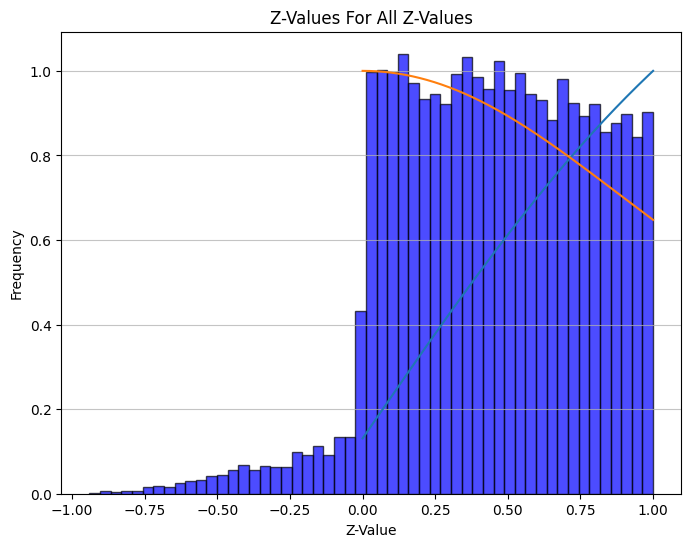

In [42]:
z_vals_random_pos = [z for z in z_vals_random if z > 0]
plt.figure(figsize=(8, 6))
plt.plot(xs, ys, '-', label=['CDF', 'density'])
plt.hist(z_vals_random, bins="auto", color="blue", edgecolor="black", alpha=0.7, density="True")
plt.title("Z-Values For All Z-Values")
plt.xlabel("Z-Value")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()

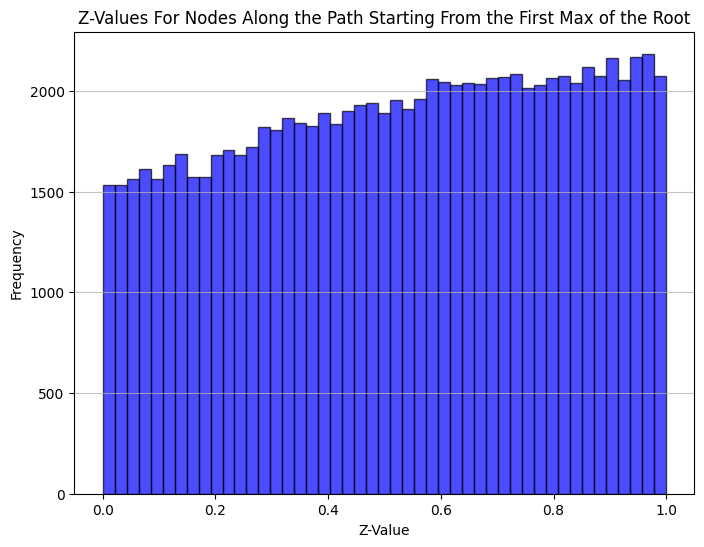

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(z_vals_along_path, bins="auto", color="blue", edgecolor="black", alpha=0.7)
plt.title("Z-Values For Nodes Along the Path Starting From the First Max of the Root")
plt.xlabel("Z-Value")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()

In [18]:
xs, ys = zs.compute_z_pdf(0.7, 10000)

NameError: name 'zs' is not defined

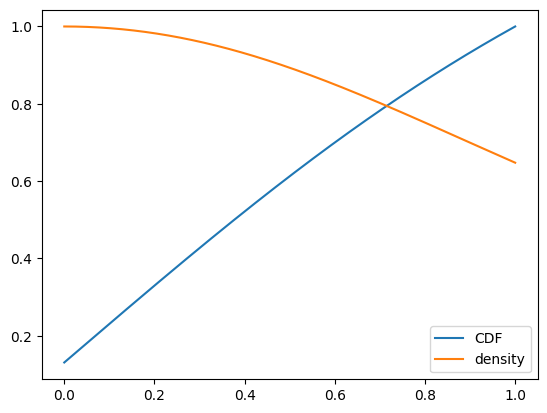

In [18]:
plt.figure()
plt.plot(xs, ys, '-', label=['CDF', 'density'])
plt.legend()